In [21]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s: %(message)s')
logger = logging.getLogger(__name__)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import joblib
from sklearn.ensemble import VotingClassifier
import lightgbm as lgb

print('Imports loaded')

Imports loaded


In [22]:
# Load the dataset
print('Loading dataframe...')
df = pd.read_csv('data/TOI_2025.10.04_05.29.58.csv', comment='#', on_bad_lines='skip')
df = df.drop(columns=['toi', 'tid', 'toi_created', 'rowupdate'])
print('Dataframe loaded successfully!\n')

print('Dataframe shape:', df.shape, '\n')

Loading dataframe...
Dataframe loaded successfully!

Dataframe shape: (7703, 19) 



In [23]:
# --- Data Cleaning ---
# Drop rows with missing values
df.dropna(inplace=True)
print('Dataframe shape after dropping missing values:', df.shape, '\n')


Dataframe shape after dropping missing values: (6589, 19) 



In [24]:
# --- Feature Selection ---
# Select numerical features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Remove transit time column (if present) as it's a timestamp
if 'pl_tranmid' in numeric_cols:
    numeric_cols.remove('pl_tranmid')



In [25]:
# Prepare X and y
X = df[numeric_cols].copy()
y = df['tfopwg_disp'].copy()

print('Features used (numerical):', numeric_cols)
print('Missing values per feature:')
display(X.isnull().sum())

Features used (numerical): ['ra', 'dec', 'st_pmra', 'st_pmdec', 'pl_orbper', 'pl_trandurh', 'pl_trandep', 'pl_rade', 'pl_insol', 'pl_eqt', 'st_tmag', 'st_dist', 'st_teff', 'st_logg', 'st_rad']
Missing values per feature:


ra             0
dec            0
st_pmra        0
st_pmdec       0
pl_orbper      0
pl_trandurh    0
pl_trandep     0
pl_rade        0
pl_insol       0
pl_eqt         0
st_tmag        0
st_dist        0
st_teff        0
st_logg        0
st_rad         0
dtype: int64

In [ ]:
# --- One-vs-Rest training moved to separate per-category cells
# The original loop has been split: define and run the per-category training cells below
import time
classifiers = {}
# Run the helper cell and then each per-category training cell to populate `classifiers`


2025-10-05 09:23:57,715 INFO: Starting training for category: FP
2025-10-05 09:23:57,720 INFO: Train/test split sizes for 'FP': 5271 train, 1318 test
2025-10-05 09:23:57,720 INFO: Train/test split sizes for 'FP': 5271 train, 1318 test
2025-10-05 09:23:57,731 INFO: Starting GridSearchCV for 'FP' with param grid: {'lgbm__n_estimators': [100, 200, 500], 'lgbm__learning_rate': [0.01, 0.05, 0.1], 'lgbm__num_leaves': [31, 50, 70]}
2025-10-05 09:23:57,731 INFO: Starting GridSearchCV for 'FP' with param grid: {'lgbm__n_estimators': [100, 200, 500], 'lgbm__learning_rate': [0.01, 0.05, 0.1], 'lgbm__num_leaves': [31, 50, 70]}
2025-10-05 09:25:54,699 INFO: GridSearchCV finished for 'FP' in 117.0s
2025-10-05 09:25:54,700 INFO: Best parameters for FP: {'lgbm__learning_rate': 0.1, 'lgbm__n_estimators': 500, 'lgbm__num_leaves': 70}
2025-10-05 09:25:54,700 INFO: Best CV score for FP: 0.3902
2025-10-05 09:25:54,701 INFO: Fitting LGBMClassifier (sklearn API) for 'FP' with early_stopping_rounds=50
2025-10

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.319296


2025-10-05 09:27:42,133 INFO: GridSearchCV finished for 'PC' in 107.2s
2025-10-05 09:27:42,134 INFO: Best parameters for PC: {'lgbm__learning_rate': 0.1, 'lgbm__n_estimators': 100, 'lgbm__num_leaves': 70}
2025-10-05 09:27:42,134 INFO: Best CV score for PC: 0.7939
2025-10-05 09:27:42,135 INFO: Fitting LGBMClassifier (sklearn API) for 'PC' with early_stopping_rounds=50
2025-10-05 09:27:42,135 WARNING: sklearn fit with early_stopping_rounds raised TypeError for 'PC': LGBMClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'. Trying callbacks API...
2025-10-05 09:27:42,134 INFO: Best parameters for PC: {'lgbm__learning_rate': 0.1, 'lgbm__n_estimators': 100, 'lgbm__num_leaves': 70}
2025-10-05 09:27:42,134 INFO: Best CV score for PC: 0.7939
2025-10-05 09:27:42,135 INFO: Fitting LGBMClassifier (sklearn API) for 'PC' with early_stopping_rounds=50
2025-10-05 09:27:42,135 WARNING: sklearn fit with early_stopping_rounds raised TypeError for 'PC': LGBMClassifier.fit() got an 

Training until validation scores don't improve for 50 rounds


2025-10-05 09:27:42,359 INFO: sklearn fit with callbacks complete for 'PC'
2025-10-05 09:27:42,372 INFO: Evaluation for 'PC':
              precision    recall  f1-score   support

           0       0.72      0.63      0.67       517
           1       0.78      0.84      0.81       801

    accuracy                           0.76      1318
   macro avg       0.75      0.74      0.74      1318
weighted avg       0.76      0.76      0.76      1318

2025-10-05 09:27:42,373 INFO: Finished category 'PC' in 107.5s
2025-10-05 09:27:42,374 INFO: Starting training for category: KP
2025-10-05 09:27:42,382 INFO: Train/test split sizes for 'KP': 5271 train, 1318 test
2025-10-05 09:27:42,372 INFO: Evaluation for 'PC':
              precision    recall  f1-score   support

           0       0.72      0.63      0.67       517
           1       0.78      0.84      0.81       801

    accuracy                           0.76      1318
   macro avg       0.75      0.74      0.74      1318
weighted av

Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.504887


2025-10-05 09:29:28,387 INFO: GridSearchCV finished for 'KP' in 106.0s
2025-10-05 09:29:28,387 INFO: Best parameters for KP: {'lgbm__learning_rate': 0.1, 'lgbm__n_estimators': 500, 'lgbm__num_leaves': 31}
2025-10-05 09:29:28,388 INFO: Best CV score for KP: 0.4207
2025-10-05 09:29:28,388 INFO: Fitting LGBMClassifier (sklearn API) for 'KP' with early_stopping_rounds=50
2025-10-05 09:29:28,389 WARNING: sklearn fit with early_stopping_rounds raised TypeError for 'KP': LGBMClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'. Trying callbacks API...
2025-10-05 09:29:28,387 INFO: Best parameters for KP: {'lgbm__learning_rate': 0.1, 'lgbm__n_estimators': 500, 'lgbm__num_leaves': 31}
2025-10-05 09:29:28,388 INFO: Best CV score for KP: 0.4207
2025-10-05 09:29:28,388 INFO: Fitting LGBMClassifier (sklearn API) for 'KP' with early_stopping_rounds=50
2025-10-05 09:29:28,389 WARNING: sklearn fit with early_stopping_rounds raised TypeError for 'KP': LGBMClassifier.fit() got an 

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.166035


2025-10-05 09:31:11,451 INFO: GridSearchCV finished for 'APC' in 102.9s
2025-10-05 09:31:11,452 INFO: Best parameters for APC: {'lgbm__learning_rate': 0.1, 'lgbm__n_estimators': 500, 'lgbm__num_leaves': 50}
2025-10-05 09:31:11,453 INFO: Best CV score for APC: 0.1254
2025-10-05 09:31:11,453 INFO: Fitting LGBMClassifier (sklearn API) for 'APC' with early_stopping_rounds=50
2025-10-05 09:31:11,454 WARNING: sklearn fit with early_stopping_rounds raised TypeError for 'APC': LGBMClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'. Trying callbacks API...
2025-10-05 09:31:11,452 INFO: Best parameters for APC: {'lgbm__learning_rate': 0.1, 'lgbm__n_estimators': 500, 'lgbm__num_leaves': 50}
2025-10-05 09:31:11,453 INFO: Best CV score for APC: 0.1254
2025-10-05 09:31:11,453 INFO: Fitting LGBMClassifier (sklearn API) for 'APC' with early_stopping_rounds=50
2025-10-05 09:31:11,454 WARNING: sklearn fit with early_stopping_rounds raised TypeError for 'APC': LGBMClassifier.fit(

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.17604


2025-10-05 09:32:33,119 INFO: GridSearchCV finished for 'FA' in 81.5s
2025-10-05 09:32:33,119 INFO: Best parameters for FA: {'lgbm__learning_rate': 0.01, 'lgbm__n_estimators': 100, 'lgbm__num_leaves': 31}
2025-10-05 09:32:33,120 INFO: Best CV score for FA: 0.0000
2025-10-05 09:32:33,120 INFO: Fitting LGBMClassifier (sklearn API) for 'FA' with early_stopping_rounds=50
2025-10-05 09:32:33,120 WARNING: sklearn fit with early_stopping_rounds raised TypeError for 'FA': LGBMClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'. Trying callbacks API...
2025-10-05 09:32:33,119 INFO: Best parameters for FA: {'lgbm__learning_rate': 0.01, 'lgbm__n_estimators': 100, 'lgbm__num_leaves': 31}
2025-10-05 09:32:33,120 INFO: Best CV score for FA: 0.0000
2025-10-05 09:32:33,120 INFO: Fitting LGBMClassifier (sklearn API) for 'FA' with early_stopping_rounds=50
2025-10-05 09:32:33,120 WARNING: sklearn fit with early_stopping_rounds raised TypeError for 'FA': LGBMClassifier.fit() got an

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[79]	valid_0's binary_logloss: 0.0509441


2025-10-05 09:34:33,571 INFO: GridSearchCV finished for 'CP' in 120.3s
2025-10-05 09:34:33,572 INFO: Best parameters for CP: {'lgbm__learning_rate': 0.1, 'lgbm__n_estimators': 500, 'lgbm__num_leaves': 70}
2025-10-05 09:34:33,572 INFO: Best CV score for CP: 0.4307
2025-10-05 09:34:33,572 INFO: Fitting LGBMClassifier (sklearn API) for 'CP' with early_stopping_rounds=50
2025-10-05 09:34:33,573 WARNING: sklearn fit with early_stopping_rounds raised TypeError for 'CP': LGBMClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'. Trying callbacks API...
2025-10-05 09:34:33,572 INFO: Best parameters for CP: {'lgbm__learning_rate': 0.1, 'lgbm__n_estimators': 500, 'lgbm__num_leaves': 70}
2025-10-05 09:34:33,572 INFO: Best CV score for CP: 0.4307
2025-10-05 09:34:33,572 INFO: Fitting LGBMClassifier (sklearn API) for 'CP' with early_stopping_rounds=50
2025-10-05 09:34:33,573 WARNING: sklearn fit with early_stopping_rounds raised TypeError for 'CP': LGBMClassifier.fit() got an 

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.2344


In [ ]:
# Helper: train a single category and return a fitted pipeline
def train_category(category, X, y, random_state=42, param_grid=None):
    import time
    logger.info(f"Starting training for category: {category}")
    t_start_cat = time.time()

    y_binary = (y == category).astype(int)
    # Split (try stratify)
    try:
        X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=random_state, stratify=y_binary)
    except ValueError:
        X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=random_state)

    preproc = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
    ])
    X_train_t = preproc.fit_transform(X_train)
    X_test_t = preproc.transform(X_test)

    search_pipe = Pipeline([('lgbm', lgb.LGBMClassifier(random_state=42, verbose=-1))])
    if param_grid is None:
        param_grid = {
            'lgbm__n_estimators': [100, 200, 500],
            'lgbm__learning_rate': [0.01, 0.05, 0.1],
            'lgbm__num_leaves': [31, 50, 70],
        }
    grid = GridSearchCV(search_pipe, param_grid, cv=3, n_jobs=-1, scoring='f1')
    grid.fit(X_train_t, y_train)
    logger.info(f"GridSearchCV finished for '{category}' in {time.time() - t_start_cat:.1f}s")

    lgbm_params = {k.split('__',1)[1]: v for k, v in grid.best_params_.items() if k.startswith('lgbm__')}
    clf = lgb.LGBMClassifier(random_state=42, verbose=-1, **lgbm_params)
    clf.set_params(n_estimators=5000)

    # Fit with early stopping (try sklearn API, then callbacks, then native train)
    try:
        clf.fit(X_train_t, y_train, eval_set=[(X_test_t, y_test)], early_stopping_rounds=50, verbose=False)
    except TypeError:
        try:
            clf.fit(X_train_t, y_train, eval_set=[(X_test_t, y_test)], callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)])
        except Exception:
            dtrain = lgb.Dataset(X_train_t, label=y_train)
            dvalid = lgb.Dataset(X_test_t, label=y_test, reference=dtrain)
            params = clf.get_params()
            native_params = {
                'learning_rate': params.get('learning_rate', 0.1),
                'num_leaves': params.get('num_leaves', 31),
                'max_depth': params.get('max_depth', -1),
                'min_data_in_leaf': params.get('min_child_samples', 20),
                'subsample': params.get('subsample', 1.0),
                'colsample_bytree': params.get('colsample_bytree', 1.0),
                'reg_alpha': params.get('reg_alpha', 0.0),
                'reg_lambda': params.get('reg_lambda', 0.0),
                'objective': 'binary',
                'verbosity': -1,
            }
            gbm = lgb.train(native_params, dtrain, num_boost_round=5000, valid_sets=[dvalid], early_stopping_rounds=50, verbose_eval=False)
            class _NativeWrapper:
                def __init__(self, booster):
                    self.booster_ = booster
                def predict(self, X):
                    probs = self.booster_.predict(X, num_iteration=self.booster_.best_iteration)
                    return (probs > 0.5).astype(int)
                def predict_proba(self, X):
                    probs = self.booster_.predict(X, num_iteration=self.booster_.best_iteration)
                    return np.vstack([1 - probs, probs]).T
            clf = _NativeWrapper(gbm)

    y_pred = clf.predict(X_test_t)
    logger.info(f"Evaluation for '{category}':\n{classification_report(y_test, y_pred)}")

    pipeline = Pipeline([('preproc', preproc), ('lgbm', clf)])
    logger.info(f"Finished category '{category}' in {time.time() - t_start_cat:.1f}s")
    return pipeline


In [ ]:
# --- Train category: APC
clf = train_category('APC', X, y)
classifiers['APC'] = clf


In [ ]:
# --- Train category: CP
clf = train_category('CP', X, y)
classifiers['CP'] = clf


In [ ]:
# --- Train category: FA
clf = train_category('FA', X, y)
classifiers['FA'] = clf


In [ ]:
# --- Train category: FP
clf = train_category('FP', X, y)
classifiers['FP'] = clf


In [ ]:
# --- Train category: KP
clf = train_category('KP', X, y)
classifiers['KP'] = clf


In [ ]:
# --- Train category: PC
clf = train_category('PC', X, y)
classifiers['PC'] = clf


Classification report for VotingClassifier:

              precision    recall  f1-score   support

         APC       0.34      0.15      0.21        71
          CP       0.62      0.44      0.52       133
          FA       1.00      0.08      0.14        13
          FP       0.59      0.46      0.51       188
          KP       0.64      0.45      0.53       112
          PC       0.75      0.90      0.81       801

    accuracy                           0.70      1318
   macro avg       0.66      0.41      0.46      1318
weighted avg       0.68      0.70      0.68      1318



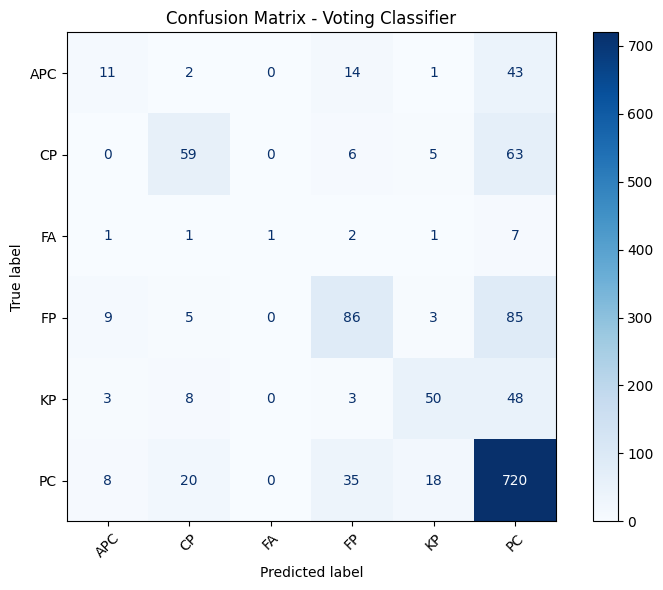

In [ ]:
# --- Meta-Classifier (use pretrained per-category classifiers) ---
# We will not call VotingClassifier.fit because it would retrain estimators.
# Instead we construct a small wrapper that uses the already-trained `classifiers` dict.
from sklearn.base import BaseEstimator, ClassifierMixin

class VotingFromPretrained(BaseEstimator, ClassifierMixin):
    def __init__(self, estimators):
        # estimators: dict name->fitted_pipeline (preproc + clf)
        self.estimators = estimators
        self.class_order = list(estimators.keys())

    def predict_proba(self, X):
        # collect prob of positive class for each binary estimator
        probs = np.column_stack([
            self.estimators[c].predict_proba(X)[:, 1] for c in self.class_order
        ])
        # normalize rows to sum to 1 (so columns mimic multiclass probs)
        row_sums = probs.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1.0
        return probs / row_sums

    def predict(self, X):
        probs = self.predict_proba(X)
        idx = np.argmax(probs, axis=1)
        return np.array([self.class_order[i] for i in idx])

# build meta-ensemble from pretrained classifiers
meta = VotingFromPretrained(classifiers)

# Evaluate on holdout split (use same split convention as before)
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
y_pred_multi = meta.predict(X_test_multi)
print('Classification report for pretrained ensemble:\n')
print(classification_report(y_test_multi, y_pred_multi))

# Confusion matrix
class_order = meta.class_order
cm = confusion_matrix(y_test_multi, y_pred_multi, labels=class_order)
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_order)
disp.plot(cmap='Blues', ax=ax, xticks_rotation=45)
ax.set_title('Confusion Matrix - Pretrained Ensemble')
plt.tight_layout()
plt.show()